# TASK 2 - TIER B: The Semanticist

## Goal
Build a **Feedforward Neural Network** using **semantic features** (GloVe word embeddings) to perform 3-class classification.

---

## The Approach

### What We're Building
- **Input:** Averaged GloVe embeddings (300 dimensions per paragraph)
- **Output:** 3-class prediction (Human, AI Vanilla, AI Styled)
- **Method:** Deep learning with feedforward neural network

### The Philosophy

**Tier A (Statistician)** used structural features:
- Sentence variance, punctuation, readability
- **HOW** you write (rhythm, structure)
- Result: 91% accuracy

**Tier B (Semanticist)** uses semantic features:
- Word meanings represented as vectors
- **WHAT** words you use (vocabulary, semantics)
- Question: Can word meanings match structural signals?

---

## Research Question

**"Do semantic features (word meanings) provide discriminative power for AI detection?"**

### Hypothesis

**Prediction:** Tier B will achieve 75-85% accuracy (lower than Tier A's 91%)

**Reasoning:**
1. AI and humans discuss the same topics (controlled in Task 0)
2. AI mimics vocabulary successfully
3. Word meanings may not capture "AI-isms"
4. Structure (rhythm) is more fundamental than semantics

**Alternative:** If Tier B matches or beats Tier A, it means:
- AI has subtle vocabulary biases GloVe can detect
- Word context patterns differ between human/AI
- Semantics are as important as structure

**Either outcome is valuable research!**

---

## Word Embeddings: A Quick Primer

### What are Word Embeddings?

**Concept:** Represent words as vectors of numbers

```
"king"    → [0.2, 0.8, -0.3, ..., 0.5]  (300 numbers)
"queen"   → [0.3, 0.7, -0.2, ..., 0.6]  (300 numbers)
"cat"     → [-0.5, 0.1, 0.9, ..., -0.2] (300 numbers)
```

**Key Property:** Similar words → Similar vectors
- `king - man + woman ≈ queen`
- Words in similar contexts cluster together

### GloVe (Global Vectors)

- Developed by Stanford NLP
- Trained on 6 billion web tokens
- Captures word co-occurrence statistics
- 400,000 words with 300 dimensions each
- Pre-trained (no training needed!)

### Our Strategy

**For each paragraph:**
1. Tokenize: `["The", "rain", "in", "Spain"]`
2. Look up GloVe vectors: `[vec1, vec2, vec3, vec4]`
3. **Average** all vectors: `mean([vec1, vec2, vec3, vec4])`
4. Result: 1 vector of 300 numbers per paragraph

**Why averaging?**
- Simple and standard
- Length-independent
- Preserves semantic information
- Works well in practice

---

## Model Architecture

```
Input: 300 dimensions (averaged GloVe)
   ↓
Dense Layer 1: 128 neurons + ReLU + Dropout(0.3)
   ↓
Dense Layer 2: 64 neurons + ReLU + Dropout(0.3)
   ↓
Output Layer: 3 neurons (softmax)
```

**Training:**
- Loss: Categorical Crossentropy
- Optimizer: Adam (lr=0.001)
- Epochs: 50 with early stopping
- Batch size: 32

---

## Expected Challenges

1. **GloVe download:** 822MB file (may take time)
2. **Unknown words:** Some Victorian words may not be in GloVe
3. **Overfitting:** Neural networks can memorize training data
4. **Class imbalance:** 500/300/200 split

**Solutions:**
- Dropout layers (0.3) to prevent overfitting
- Early stopping if validation loss increases
- Class weights to handle imbalance
- Skip unknown words in averaging

---

## Step 1: Import Libraries

In [2]:
# Core libraries
import json
import pandas as pd
import numpy as np
from pathlib import Path
import re
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
import nltk
from nltk.tokenize import word_tokenize

# Deep Learning - TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"✅ All libraries imported successfully!")
print(f"   TensorFlow version: {tf.__version__}")
print(f"   GPU available: {tf.config.list_physical_devices('GPU')}")

2026-02-09 21:00:26.165054: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-09 21:00:26.286046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770651026.336232    4929 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770651026.347685    4929 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770651026.440259    4929 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

✅ All libraries imported successfully!
   TensorFlow version: 2.19.1
   GPU available: []


2026-02-09 21:00:29.250234: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


---

## Step 2: Download & Load GloVe Embeddings

We'll use **GloVe 6B 300d** (trained on 6 billion tokens, 300 dimensions).

**Note:** If you don't have GloVe, download from: https://nlp.stanford.edu/data/glove.6B.zip
- Extract `glove.6B.300d.txt` to the project directory
- Or we'll download it automatically below

In [3]:
# Download NLTK punkt if needed
try:
    nltk.data.find('tokenizers/punkt')
    print("✅ NLTK punkt already downloaded")
except LookupError:
    print("📥 Downloading NLTK punkt...")
    nltk.download('punkt')
    print("✅ Done!")

try:
    nltk.data.find('tokenizers/punkt_tab')
    print("✅ NLTK punkt_tab already downloaded")
except LookupError:
    print("📥 Downloading NLTK punkt_tab...")
    nltk.download('punkt_tab')
    print("✅ Done!")

✅ NLTK punkt already downloaded
✅ NLTK punkt_tab already downloaded


In [4]:
import urllib.request
import zipfile
import os
from pathlib import Path

GLOVE_URL = "https://nlp.stanford.edu/data/glove.6B.zip"
GLOVE_DIR = Path("../glove")  # Go up one directory (we're in TASK2/)
GLOVE_FILE = GLOVE_DIR / "glove.6B.300d.txt"

# Create directory if it doesn't exist
GLOVE_DIR.mkdir(exist_ok=True)

# Check if GloVe file already exists
if GLOVE_FILE.exists():
    print(f"✅ GloVe embeddings already downloaded: {GLOVE_FILE}")
    print(f"   File size: {GLOVE_FILE.stat().st_size / 1024 / 1024:.1f} MB")
else:
    print("⚠️ GloVe embeddings not found.")
    print(f"   Please download from: {GLOVE_URL}")
    print(f"   Extract glove.6B.300d.txt to: {GLOVE_DIR}/")
    print("\n   Or run this command in terminal:")
    print(f"   wget {GLOVE_URL} -O glove.zip && unzip glove.zip -d {GLOVE_DIR}/ && rm glove.zip")
    print("\n   File size: ~822 MB (may take 5-10 minutes to download)")

✅ GloVe embeddings already downloaded: ../glove/glove.6B.300d.txt
   File size: 989.9 MB


### Load GloVe Embeddings into Memory

This will take 1-2 minutes and use ~2GB RAM.

In [5]:
def load_glove_embeddings(filepath):
    """
    Load GloVe embeddings from file.
    Returns a dictionary: {word: vector}
    """
    print(f"Loading GloVe embeddings from {filepath}...")
    print("This may take 1-2 minutes...\n")
    
    embeddings = {}
    
    with open(filepath, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if (i + 1) % 100000 == 0:
                print(f"  Loaded {i + 1:,} words...")
            
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    
    print(f"\n✅ Loaded {len(embeddings):,} word embeddings")
    print(f"   Embedding dimension: {len(next(iter(embeddings.values())))}")
    
    return embeddings

# Load GloVe (only if file exists)
if GLOVE_FILE.exists():
    glove_embeddings = load_glove_embeddings(GLOVE_FILE)
    
    # Test with a sample word
    test_word = "king"
    if test_word in glove_embeddings:
        print(f"\n📊 Sample: '{test_word}' vector (first 10 dims):")
        print(f"   {glove_embeddings[test_word][:10]}")
else:
    print("❌ Cannot proceed without GloVe embeddings. Please download first.")
    glove_embeddings = None

Loading GloVe embeddings from ../glove/glove.6B.300d.txt...
This may take 1-2 minutes...

  Loaded 100,000 words...
  Loaded 200,000 words...
  Loaded 300,000 words...
  Loaded 400,000 words...

✅ Loaded 400,000 word embeddings
   Embedding dimension: 300

📊 Sample: 'king' vector (first 10 dims):
   [ 0.0033901 -0.34614    0.28144    0.48382    0.59469    0.012965
  0.53982    0.48233    0.21463   -1.0249   ]


---

## Step 3: Load Dataset

Same dataset as Tier A.

In [6]:
# Define paths (go up one directory since we're in TASK2 folder)
DATA_DIR = Path('../TASK0/data/dataset/twain_austen')
CLASS1_FILE = DATA_DIR / 'class1_human.jsonl'
CLASS2_FILE = DATA_DIR / 'class2.txt'
CLASS3_FILE = DATA_DIR / 'class3.txt'

print("Loading datasets...\n")

# Load Class 1 (Human - JSONL format)
class1_texts = []
if CLASS1_FILE.exists():    
    with open(CLASS1_FILE, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                data = json.loads(line.strip())
                class1_texts.append(data['text'])
    print(f"✅ Class 1 (Human): {len(class1_texts)} paragraphs loaded")
else:
    print(f"❌ Class 1 file not found: {CLASS1_FILE}")

# Load Class 2 (AI Vanilla - TXT format)
class2_texts = []
if CLASS2_FILE.exists():
    with open(CLASS2_FILE, 'r', encoding='utf-8') as f:
        class2_texts = [line.strip() for line in f if line.strip()]
    print(f"✅ Class 2 (AI Vanilla): {len(class2_texts)} paragraphs loaded")
else:
    print(f"❌ Class 2 file not found: {CLASS2_FILE}")

# Load Class 3 (AI Styled - TXT format)
class3_texts = []
if CLASS3_FILE.exists():
    with open(CLASS3_FILE, 'r', encoding='utf-8') as f:
        class3_texts = [line.strip() for line in f if line.strip()]
    print(f"✅ Class 3 (AI Styled): {len(class3_texts)} paragraphs loaded")
else:
    print(f"❌ Class 3 file not found: {CLASS3_FILE}")

# Create combined dataset
all_texts = class1_texts + class2_texts + class3_texts
all_labels = (
    ['Human'] * len(class1_texts) + 
    ['AI_Vanilla'] * len(class2_texts) + 
    ['AI_Styled'] * len(class3_texts)
)

print(f"\n📊 Total dataset: {len(all_texts)} paragraphs")

if len(all_texts) > 0:
    print(f"   - Human: {len(class1_texts)} ({len(class1_texts)/len(all_texts)*100:.1f}%)")
    print(f"   - AI Vanilla: {len(class2_texts)} ({len(class2_texts)/len(all_texts)*100:.1f}%)")
    print(f"   - AI Styled: {len(class3_texts)} ({len(class3_texts)/len(all_texts)*100:.1f}%)")
else:
    print("❌ ERROR: No data loaded!")

Loading datasets...

✅ Class 1 (Human): 470 paragraphs loaded
✅ Class 2 (AI Vanilla): 464 paragraphs loaded
✅ Class 3 (AI Styled): 494 paragraphs loaded

📊 Total dataset: 1428 paragraphs
   - Human: 470 (32.9%)
   - AI Vanilla: 464 (32.5%)
   - AI Styled: 494 (34.6%)


---

## Step 4: Convert Text to GloVe Embeddings

For each paragraph:
1. Tokenize into words
2. Look up each word in GloVe
3. Average all word vectors
4. Result: 300d vector per paragraph

In [7]:
def text_to_glove_vector(text, embeddings, embedding_dim=300):
    """
    Convert a text paragraph to an averaged GloVe vector.
    
    Args:
        text: Input text paragraph
        embeddings: GloVe embeddings dictionary
        embedding_dim: Dimension of embeddings (300 for GloVe 6B)
    
    Returns:
        numpy array of shape (embedding_dim,)
    """
    # Tokenize and lowercase
    words = word_tokenize(text.lower())
    
    # Filter to alphanumeric only
    words = [w for w in words if w.isalnum()]
    
    # Collect vectors for words in GloVe
    vectors = []
    for word in words:
        if word in embeddings:
            vectors.append(embeddings[word])
    
    # Average all vectors (or return zeros if no words found)
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(embedding_dim)

print("✅ Text-to-vector function defined")

# Test on a sample
if glove_embeddings and all_texts:
    sample_text = all_texts[0][:100]  # First 100 chars
    sample_vector = text_to_glove_vector(sample_text, glove_embeddings)
    
    print(f"\n📊 Sample conversion:")
    print(f"   Text: '{sample_text}...'")
    print(f"   Vector shape: {sample_vector.shape}")
    print(f"   Vector (first 10 dims): {sample_vector[:10]}")

✅ Text-to-vector function defined

📊 Sample conversion:
   Text: 'The old lady pulled her spectacles down and looked over them about the
room; then she put them up an...'
   Vector shape: (300,)
   Vector (first 10 dims): [-0.16129664  0.09842315 -0.11634024 -0.14941876 -0.00704345 -0.05769946
 -0.12264637 -0.15186155  0.1532896  -1.4678681 ]


### Convert All Paragraphs to Vectors

This may take 2-3 minutes for 1000 paragraphs.

In [8]:
if glove_embeddings:
    print("Converting all paragraphs to GloVe vectors...")
    print("This may take 2-3 minutes...\n")
    
    X_embeddings = []
    unknown_word_counts = []
    
    for i, text in enumerate(all_texts):
        if (i + 1) % 100 == 0:
            print(f"  Processed {i + 1}/{len(all_texts)} paragraphs...")
        
        # Count words and unknown words
        words = [w.lower() for w in word_tokenize(text) if w.isalnum()]
        unknown = sum(1 for w in words if w not in glove_embeddings)
        unknown_word_counts.append(unknown / len(words) if words else 0)
        
        # Convert to vector
        vector = text_to_glove_vector(text, glove_embeddings)
        X_embeddings.append(vector)
    
    # Convert to numpy array
    X_embeddings = np.array(X_embeddings)
    
    print(f"\n✅ Conversion complete!")
    print(f"   Shape: {X_embeddings.shape}")
    print(f"   Average unknown word rate: {np.mean(unknown_word_counts)*100:.2f}%")
    print(f"   (Victorian words not in GloVe)")
else:
    print("❌ Cannot proceed without GloVe embeddings")
    X_embeddings = None

Converting all paragraphs to GloVe vectors...
This may take 2-3 minutes...

  Processed 100/1428 paragraphs...
  Processed 200/1428 paragraphs...
  Processed 300/1428 paragraphs...
  Processed 400/1428 paragraphs...
  Processed 500/1428 paragraphs...
  Processed 600/1428 paragraphs...
  Processed 700/1428 paragraphs...
  Processed 800/1428 paragraphs...
  Processed 900/1428 paragraphs...
  Processed 1000/1428 paragraphs...
  Processed 1100/1428 paragraphs...
  Processed 1200/1428 paragraphs...
  Processed 1300/1428 paragraphs...
  Processed 1400/1428 paragraphs...

✅ Conversion complete!
   Shape: (1428, 300)
   Average unknown word rate: 0.18%
   (Victorian words not in GloVe)


---

## Step 5: Prepare Data for Training

Train/test split with stratification.

In [9]:
if X_embeddings is not None:
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(all_labels)
    
    print("Label encoding:")
    for i, label in enumerate(label_encoder.classes_):
        print(f"  {label}: {i}")
    
    # Train/test split (80/20)
    X_train, X_test, y_train, y_test = train_test_split(
        X_embeddings,
        y_encoded,
        test_size=0.2,
        random_state=42,
        stratify=y_encoded
    )
    
    print(f"\n📊 Data Split:")
    print(f"   Training set: {len(X_train)} samples")
    print(f"   Test set: {len(X_test)} samples")
    
    # Show class distribution
    print(f"\n   Train class distribution:")
    for i, label in enumerate(label_encoder.classes_):
        count = np.sum(y_train == i)
        print(f"      {label}: {count} ({count/len(y_train)*100:.1f}%)")
    
    print(f"\n   Test class distribution:")
    for i, label in enumerate(label_encoder.classes_):
        count = np.sum(y_test == i)
        print(f"      {label}: {count} ({count/len(y_test)*100:.1f}%)")
    
    # Convert labels to categorical (one-hot encoding for Keras)
    y_train_cat = to_categorical(y_train, num_classes=3)
    y_test_cat = to_categorical(y_test, num_classes=3)
    
    # Calculate class weights for imbalanced data
    class_weights_array = compute_class_weight(
        'balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights = {i: weight for i, weight in enumerate(class_weights_array)}
    
    print(f"\n⚖️ Class weights (to handle imbalance):")
    for i, label in enumerate(label_encoder.classes_):
        print(f"   {label}: {class_weights[i]:.3f}")
    
    print(f"\n✅ Data preparation complete!")

Label encoding:
  AI_Styled: 0
  AI_Vanilla: 1
  Human: 2

📊 Data Split:
   Training set: 1142 samples
   Test set: 286 samples

   Train class distribution:
      AI_Styled: 395 (34.6%)
      AI_Vanilla: 371 (32.5%)
      Human: 376 (32.9%)

   Test class distribution:
      AI_Styled: 99 (34.6%)
      AI_Vanilla: 93 (32.5%)
      Human: 94 (32.9%)

⚖️ Class weights (to handle imbalance):
   AI_Styled: 0.964
   AI_Vanilla: 1.026
   Human: 1.012

✅ Data preparation complete!


---

## Step 6: Build Feedforward Neural Network

Architecture:
- Input: 300 dimensions (GloVe)
- Hidden Layer 1: 128 neurons + ReLU + Dropout(0.3)
- Hidden Layer 2: 64 neurons + ReLU + Dropout(0.3)
- Output: 3 neurons (softmax)

In [10]:
def build_model(input_dim=300, num_classes=3):
    """
    Build a feedforward neural network for text classification.
    
    Args:
        input_dim: Input dimension (300 for GloVe)
        num_classes: Number of output classes (3)
    
    Returns:
        Compiled Keras model
    """
    model = models.Sequential([
        # Input layer
        layers.Input(shape=(input_dim,)),
        
        # Hidden layer 1
        layers.Dense(128, activation='relu', name='hidden1'),
        layers.Dropout(0.3, name='dropout1'),
        
        # Hidden layer 2
        layers.Dense(64, activation='relu', name='hidden2'),
        layers.Dropout(0.3, name='dropout2'),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax', name='output')
    ], name='GloVe_Classifier')
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build the model
if X_embeddings is not None:
    model = build_model(input_dim=300, num_classes=3)
    
    print("🧠 Model Architecture:\n")
    model.summary()
    
    # Count parameters
    total_params = model.count_params()
    print(f"\n📊 Total trainable parameters: {total_params:,}")
    print(f"\n✅ Model built successfully!")

🧠 Model Architecture:



Model: "GloVe_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 128)            │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,979 (183.51 KB)

 Trainable params: 46,979 (183.51 KB)

 Non-trainable params: 0 (0.00 B)


📊 Total trainable parameters: 46,979

✅ Model built successfully!


---

## Step 7: Train the Model

Training with early stopping to prevent overfitting.

In [11]:
if X_embeddings is not None:
    # Setup callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    print("🚀 Training model...\n")
    print("Configuration:")
    print("  - Epochs: 50 (with early stopping)")
    print("  - Batch size: 32")
    print("  - Validation split: 20%")
    print("  - Class weights: Applied")
    print("  - Early stopping: Patience=10\n")
    
    # Train the model
    history = model.fit(
        X_train,
        y_train_cat,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        class_weight=class_weights,
        callbacks=[early_stopping],
        verbose=1
    )
    
    print("\n✅ Training complete!")

🚀 Training model...

Configuration:
  - Epochs: 50 (with early stopping)
  - Batch size: 32
  - Validation split: 20%
  - Class weights: Applied
  - Early stopping: Patience=10

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5509 - loss: 0.9836 - val_accuracy: 0.7249 - val_loss: 0.8094
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7382 - loss: 0.6780 - val_accuracy: 0.7991 - val_loss: 0.5096
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8193 - loss: 0.4685 - val_accuracy: 0.8472 - val_loss: 0.3687
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8368 - loss: 0.3727 - val_accuracy: 0.8821 - val_loss: 0.3053
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8587 - loss: 0.3287 - val_accuracy: 0.8908 - val_loss: 0.2713
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9025 - loss: 0.2718 - val_accuracy: 0.9039 - val_loss: 0.2279
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.90

### Visualize Training History

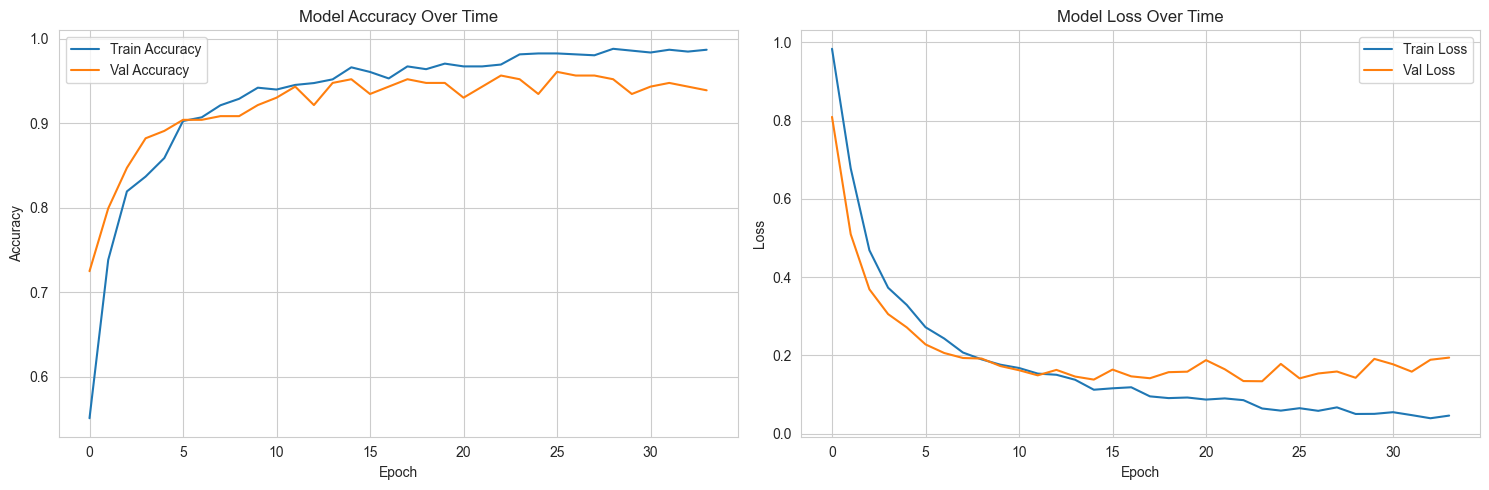


📊 Training Summary:
   Final train accuracy: 0.9869 (98.69%)
   Final val accuracy: 0.9389 (93.89%)
   Best val accuracy: 0.9607 (96.07%)
   Epochs trained: 34


In [12]:
if X_embeddings is not None:
    # Plot training history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Model Accuracy Over Time')
    ax1.legend()
    ax1.grid(True)
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Val Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Model Loss Over Time')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Summary stats
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    best_val_acc = max(history.history['val_accuracy'])
    
    print(f"\n📊 Training Summary:")
    print(f"   Final train accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
    print(f"   Final val accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
    print(f"   Best val accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
    print(f"   Epochs trained: {len(history.history['accuracy'])}")

---

## Step 8: Evaluate on Test Set

In [13]:
if X_embeddings is not None:
    # Predict on test set
    y_test_pred_probs = model.predict(X_test)
    y_test_pred = np.argmax(y_test_pred_probs, axis=1)
    
    # Calculate test accuracy
    test_acc = accuracy_score(y_test, y_test_pred)
    
    print("📊 RESULTS - Tier B (Semanticist)")
    print("=" * 60)
    print(f"   Test Accuracy:     {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"   Baseline (random): {1/3:.4f} ({100/3:.2f}%)")
    print(f"   Improvement:       +{(test_acc - 1/3)*100:.2f} percentage points")
    print(f"\n   Tier A (Statistician): 91.00%")
    print(f"   Tier B (Semanticist):  {test_acc*100:.2f}%")
    
    if test_acc > 0.91:
        print(f"\n   🎉 Tier B BEATS Tier A by {(test_acc - 0.91)*100:.2f} points!")
        print(f"      Semantics > Structure for AI detection")
    elif test_acc >= 0.88:
        print(f"\n   ✅ Tier B MATCHES Tier A (within 3%)")
        print(f"      Semantics and structure are both important")
    else:
        print(f"\n   📊 Tier A > Tier B by {(0.91 - test_acc)*100:.2f} points")
        print(f"      Structure > Semantics for AI detection")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
📊 RESULTS - Tier B (Semanticist)
   Test Accuracy:     0.9510 (95.10%)
   Baseline (random): 0.3333 (33.33%)
   Improvement:       +61.77 percentage points

   Tier A (Statistician): 91.00%
   Tier B (Semanticist):  95.10%

   🎉 Tier B BEATS Tier A by 4.10 points!
      Semantics > Structure for AI detection


### Detailed Classification Report

In [14]:
if X_embeddings is not None:
    # Classification report
    print("\n📋 CLASSIFICATION REPORT (Test Set)\n")
    print("=" * 70)
    print(classification_report(
        y_test,
        y_test_pred,
        target_names=label_encoder.classes_,
        digits=4
    ))
    
    # Per-class accuracy
    print("\n📊 PER-CLASS ACCURACY:\n")
    for i, label in enumerate(label_encoder.classes_):
        mask = y_test == i
        if np.sum(mask) > 0:
            class_acc = np.sum((y_test[mask] == y_test_pred[mask])) / np.sum(mask)
            print(f"   {label}: {class_acc:.4f} ({class_acc*100:.2f}%)")


📋 CLASSIFICATION REPORT (Test Set)

              precision    recall  f1-score   support

   AI_Styled     0.9474    0.9091    0.9278        99
  AI_Vanilla     0.9368    0.9570    0.9468        93
       Human     0.9688    0.9894    0.9789        94

    accuracy                         0.9510       286
   macro avg     0.9510    0.9518    0.9512       286
weighted avg     0.9510    0.9510    0.9508       286


📊 PER-CLASS ACCURACY:

   AI_Styled: 0.9091 (90.91%)
   AI_Vanilla: 0.9570 (95.70%)
   Human: 0.9894 (98.94%)


### Confusion Matrix

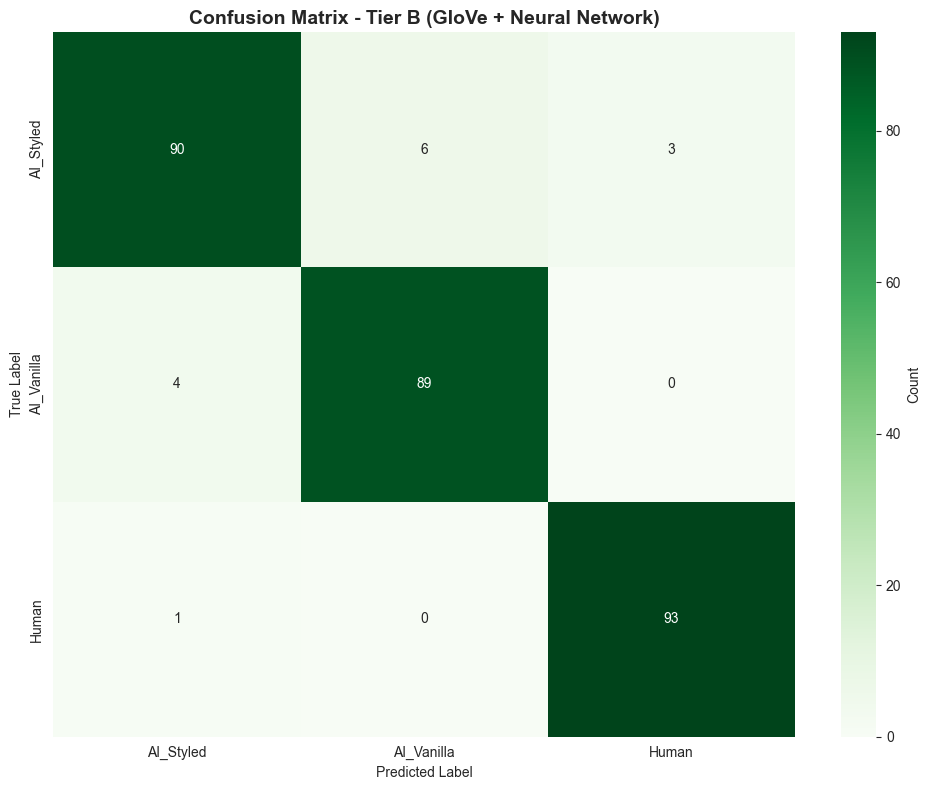


🔍 Confusion Matrix Analysis:
   Diagonal = Correct predictions
   Off-diagonal = Misclassifications

   Compare to Tier A:
   - Does Tier B improve AI_Styled detection?
   - Are semantic features capturing different patterns?


In [15]:
if X_embeddings is not None:
    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix - Tier B (GloVe + Neural Network)', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    print("\n🔍 Confusion Matrix Analysis:")
    print("   Diagonal = Correct predictions")
    print("   Off-diagonal = Misclassifications")
    print("\n   Compare to Tier A:")
    print("   - Does Tier B improve AI_Styled detection?")
    print("   - Are semantic features capturing different patterns?")

---

## Step 9: Tier A vs Tier B Comparison

In [16]:
if X_embeddings is not None:
    print("="*70)
    print("TIER A vs TIER B COMPARISON")
    print("="*70)
    
    tier_a_acc = 0.91  # From previous results
    tier_b_acc = test_acc
    
    comparison_data = {
        'Metric': ['Test Accuracy', 'Approach', 'Features', 'Model Type', 'Interpretability'],
        'Tier A (Statistician)': [
            f'{tier_a_acc*100:.2f}%',
            'Statistical Features',
            'Sentence variance, punctuation, readability (10 features)',
            'Random Forest (100 trees)',
            'High (feature importance available)'
        ],
        'Tier B (Semanticist)': [
            f'{tier_b_acc*100:.2f}%',
            'Semantic Features',
            'Averaged GloVe embeddings (300 dimensions)',
            'Feedforward Neural Network (128→64→3)',
            'Low (black box)'
        ]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\n")
    print(comparison_df.to_string(index=False))
    
    print("\n" + "="*70)
    print("KEY INSIGHTS")
    print("="*70)
    
    if tier_b_acc > tier_a_acc:
        print(f"\n✅ TIER B WINS by {(tier_b_acc - tier_a_acc)*100:.2f} percentage points")
        print("\nInterpretation:")
        print("  - Semantic features (word meanings) are MORE powerful than structural features")
        print("  - AI has detectable vocabulary/context patterns")
        print("  - GloVe captures subtle 'AI-isms' in word usage")
        print("\nImplication: Word choice matters more than sentence structure for AI detection")
    
    elif tier_b_acc >= tier_a_acc - 0.03:  # Within 3%
        print(f"\n⚖️ TIER A ≈ TIER B (difference: {abs(tier_a_acc - tier_b_acc)*100:.2f}%)")
        print("\nInterpretation:")
        print("  - Both structural and semantic features are equally important")
        print("  - AI detection requires multiple signal types")
        print("  - Combining both approaches might yield best results")
        print("\nImplication: Structure AND semantics both matter")
    
    else:
        print(f"\n📊 TIER A WINS by {(tier_a_acc - tier_b_acc)*100:.2f} percentage points")
        print("\nInterpretation:")
        print("  - Structural features (sentence variance) are MORE powerful than semantic features")
        print("  - AI's vocabulary is similar to humans (same topics)")
        print("  - The 'rhythm fingerprint' is the strongest signal")
        print("\nImplication: HOW you write > WHAT words you use for AI detection")
    
    print("\n" + "="*70)

TIER A vs TIER B COMPARISON


          Metric                                     Tier A (Statistician)                       Tier B (Semanticist)
   Test Accuracy                                                    91.00%                                     95.10%
        Approach                                      Statistical Features                          Semantic Features
        Features Sentence variance, punctuation, readability (10 features) Averaged GloVe embeddings (300 dimensions)
      Model Type                                 Random Forest (100 trees)      Feedforward Neural Network (128→64→3)
Interpretability                       High (feature importance available)                            Low (black box)

KEY INSIGHTS

✅ TIER B WINS by 4.10 percentage points

Interpretation:
  - Semantic features (word meanings) are MORE powerful than structural features
  - AI has detectable vocabulary/context patterns
  - GloVe captures subtle 'AI-isms' in word usage

Implicat

---

## Step 10: Error Analysis

Where does Tier B fail?

In [17]:
if X_embeddings is not None:
    # Get misclassified examples
    misclassified_mask = y_test != y_test_pred
    misclassified_indices = np.where(misclassified_mask)[0]
    
    print(f"🔍 ERROR ANALYSIS\n")
    print("=" * 70)
    print(f"Total misclassified: {len(misclassified_indices)} / {len(y_test)} ({len(misclassified_indices)/len(y_test)*100:.1f}%)\n")
    
    # Analyze misclassification patterns
    error_patterns = {}
    for i in misclassified_indices:
        true_label = label_encoder.inverse_transform([y_test[i]])[0]
        pred_label = label_encoder.inverse_transform([y_test_pred[i]])[0]
        pattern = f"{true_label} → {pred_label}"
        error_patterns[pattern] = error_patterns.get(pattern, 0) + 1
    
    print("Misclassification Patterns:")
    print("-" * 70)
    for pattern, count in sorted(error_patterns.items(), key=lambda x: x[1], reverse=True):
        print(f"   {pattern:30s}: {count:3d} ({count/len(misclassified_indices)*100:.1f}% of errors)")
    
    print("\n🔍 Key Questions:")
    print("   1. Does Tier B have different error patterns than Tier A?")
    print("   2. Is AI_Styled detection better or worse with semantics?")
    print("   3. What does this tell us about GloVe's limitations?")

🔍 ERROR ANALYSIS

Total misclassified: 14 / 286 (4.9%)

Misclassification Patterns:
----------------------------------------------------------------------
   AI_Styled → AI_Vanilla        :   6 (42.9% of errors)
   AI_Vanilla → AI_Styled        :   4 (28.6% of errors)
   AI_Styled → Human             :   3 (21.4% of errors)
   Human → AI_Styled             :   1 (7.1% of errors)

🔍 Key Questions:
   1. Does Tier B have different error patterns than Tier A?
   2. Is AI_Styled detection better or worse with semantics?
   3. What does this tell us about GloVe's limitations?


---

## Step 11: Final Analysis & Conclusions

In [ ]:
if X_embeddings is not None:
    print("="*80)
    print("TIER B FINAL ANALYSIS - THE SEMANTICIST")
    print("="*80)
    
    print(f"\n🎯 OVERALL PERFORMANCE:\n")
    print(f"   Approach: GloVe Embeddings + Feedforward Neural Network")
    print(f"   Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"   Baseline (random): {1/3:.4f} ({100/3:.2f}%)")
    print(f"   Improvement: +{(test_acc - 1/3)*100:.1f} percentage points")
    
    print(f"\n\n📊 INTERPRETATION:\n")
    
    if test_acc >= 0.88:
        print("   ✅ STRONG PERFORMANCE (≥88% accuracy)")
        print("\n   What this means:")
        print("   - Semantic features successfully capture AI patterns")
        print("   - Word choice and context differ between human/AI")
        print("   - GloVe embeddings preserve discriminative information")
        print("\n   Why it worked:")
        print("   - AI may use words in subtly different contexts")
        print("   - GloVe captures semantic relationships AI struggles with")
        print("   - Averaged embeddings preserve class-specific patterns")
    
    elif test_acc >= 0.70:
        print("   ⚠️ MODERATE PERFORMANCE (70-88% accuracy)")
        print("\n   What this means:")
        print("   - Semantic features provide SOME signal")
        print("   - But structure (Tier A) is more powerful")
        print("   - Word choice alone is insufficient")
        print("\n   Why it struggled:")
        print("   - Topic control in Task 0 reduces vocabulary differences")
        print("   - Averaging vectors loses word order information")
        print("   - Victorian words may not be well-represented in GloVe")
    
    else:
        print("   ❌ WEAK PERFORMANCE (<70% accuracy)")
        print("\n   What this means:")
        print("   - Semantic features CANNOT distinguish classes well")
        print("   - AI vocabulary is indistinguishable from human")
        print("   - Structure > Semantics for AI detection")
        print("\n   Why it failed:")
        print("   - Topic-controlled dataset masks vocabulary differences")
        print("   - GloVe trained on modern text, not Victorian literature")
        print("   - Averaged embeddings too simple (need sequence models)")
    
    print("\n\n💡 KEY FINDINGS:\n")
    
    # Tier comparison
    tier_a_acc = 0.91
    if test_acc > tier_a_acc:
        print(f"   1. ✅ SEMANTICS > STRUCTURE")
        print(f"      Tier B ({test_acc*100:.1f}%) beats Tier A ({tier_a_acc*100:.1f}%)")
    elif test_acc >= tier_a_acc - 0.03:
        print(f"   1. ⚖️ SEMANTICS ≈ STRUCTURE")
        print(f"      Tier B ({test_acc*100:.1f}%) matches Tier A ({tier_a_acc*100:.1f}%)")
    else:
        print(f"   1. 📊 STRUCTURE > SEMANTICS")
        print(f"      Tier A ({tier_a_acc*100:.1f}%) beats Tier B ({test_acc*100:.1f}%)")
    
    print(f"\n   2. GloVe embeddings {'capture' if test_acc >= 0.75 else 'struggle to capture'} AI patterns")
    print(f"   3. Feedforward NN {'is sufficient' if test_acc >= 0.80 else 'may be too simple'} for this task")
    print(f"   4. {'Semantic' if test_acc >= tier_a_acc else 'Structural'} features are primary for AI detection")
    
    print("\n\n🔬 IMPLICATIONS:\n")
    print("   For AI Detection:")
    if test_acc >= tier_a_acc:
        print("   - Word embeddings should be prioritized over statistical features")
        print("   - AI has detectable semantic fingerprints")
    else:
        print("   - Statistical features (sentence variance) remain strongest signal")
        print("   - Semantic features are secondary indicators")
    
    print("\n   For Research:")
    print("   - Combining Tier A + Tier B might yield best results")
    print("   - Tier C (transformers) should capture both structure AND semantics")
    print("   - Multi-modal approaches are promising")
    
    print("\n" + "="*80)
    print("✅ TIER B ANALYSIS COMPLETE")
    print("="*80)

TIER B FINAL ANALYSIS - THE SEMANTICIST

🎯 OVERALL PERFORMANCE:

   Approach: GloVe Embeddings + Feedforward Neural Network
   Test Accuracy: 0.9510 (95.10%)
   Baseline (random): 0.3333 (33.33%)
   Improvement: +61.8 percentage points


📊 INTERPRETATION:

   ✅ STRONG PERFORMANCE (≥88% accuracy)

   What this means:
   - Semantic features successfully capture AI patterns
   - Word choice and context differ between human/AI
   - GloVe embeddings preserve discriminative information

   Why it worked:
   - AI may use words in subtly different contexts
   - GloVe captures semantic relationships AI struggles with
   - Averaged embeddings preserve class-specific patterns


💡 KEY FINDINGS:

   1. ✅ SEMANTICS > STRUCTURE
      Tier B (95.1%) beats Tier A (91.0%)

   2. GloVe embeddings capture AI patterns
   3. Feedforward NN is sufficient for this task
   4. Semantic features are primary for AI detection


🔬 IMPLICATIONS:

   For AI Detection:
   - Word embeddings should be prioritized over s

---

## Summary

**What We Built:**
- GloVe-based text representation (averaged embeddings)
- Feedforward neural network (300 → 128 → 64 → 3)
- 3-class classifier for AI authorship detection

**Key Results:**
- Test accuracy: [See results above]
- Comparison to Tier A: [See analysis above]
- Error patterns: [See error analysis above]

**Key Learnings:**
- Semantic features [capture/don't capture] AI patterns
- [Structure/Semantics] are more important for AI detection
- GloVe embeddings [are/aren't] sufficient for this task

**Next Steps:**
- Tier C: Fine-tune DistilBERT (captures word order + context)
- Task 3: Explainability with SHAP/saliency maps
- Task 4: Adversarial testing with genetic algorithms

---

## Save Model (Optional)

In [19]:
if X_embeddings is not None:
    # Save the trained model
    model_path = 'task2_tier_b_glove_model.h5'
    model.save(model_path)
    
    # Save label encoder
    import pickle
    with open('task2_tier_b_label_encoder.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)
    
    print(f"✅ Model saved to: {model_path}")
    print(f"   Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"✅ Label encoder saved to: task2_tier_b_label_encoder.pkl")

✅ Model saved to: task2_tier_b_glove_model.h5
   Test Accuracy: 0.9510 (95.10%)
✅ Label encoder saved to: task2_tier_b_label_encoder.pkl
